CARGAR Y CONFIGURAR EL DATASET

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier  # Para el modelo KNN
from sklearn.model_selection import train_test_split  # Para dividir los datos en entrenamiento y prueba
from sklearn.metrics import accuracy_score  # Para evaluar la precisión del modelo
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# Cargar el dataset
df = pd.read_csv("https://drive.google.com/uc?export=download&id=18glOMWxHUOPDQa6t2mwRG6vJN1GbpiIA")

PREPROCESADO (ELIMINACION DE COLUMNS IRRELEVANTES Y VALORES NA, DESAGREGACIÓN, ESTANDARIZACIÓN, ELIMINACIÓN DATOS ATÍPICOS, CATEGORIZACIÓN)

In [3]:

# Configuración para mostrar todas las columnas y sus títulos
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.width', None)        # Asegura que no haya límite en el ancho de la salida

# Eliminamos las filas con valores nulos en las nuevas columnas
df = df.dropna().reset_index(drop=True)  # Elimina todas las filas con NA en cualquier columna

# Convertir columnas específicas a enteros
df['releaseYear'] = df['releaseYear'].astype('Int64')  # Convertir a entero, manejando nulos si los hay
df['imdbNumVotes'] = df['imdbNumVotes'].astype('Int64')  # Convertir a entero, manejando nulos si los hay

# Mostrar 15 filas aleatorias antes de eliminar columnas
print("\n15 filas aleatorias antes de eliminar columnas:\n")
print(df.sample(15, random_state=40))  # Muestra 15 filas aleatorias

# Eliminación de columnas irrelevantes
df = df.drop(['url', 'imdbId', 'availableCountries'], axis=1)
print("\n15 filas aleatorias después de eliminar columnas:\n")
print(df.sample(15, random_state=40))  # Muestra 15 filas aleatorias de la tabla

# Desagregación de tipo y géneros
df['type_new'] = np.where(df['type'] == 'movie', 0, 1)

# Función para codificar géneros
def encode_new(genres):
    encoding = [0, 0, 0]  # Cambiar 0's a enteros en lugar de cadenas
    if pd.isna(genres): return [None, None, None]
    elif 'Drama' in genres and 'Comedy' not in genres: encoding[0] = 1
    elif 'Comedy' in genres and 'Drama' not in genres: encoding[1] = 1
    elif 'Comedy' not in genres and 'Drama' not in genres: encoding[2] = 1
    else: return [None, None, None]
    return encoding

df[['drama', 'comedy', 'other']] = pd.DataFrame(df['genres'].apply(encode_new).tolist(), index=df.index)
df = df.dropna(subset=['drama', 'comedy', 'other'])
df = df.drop(['genres', 'type'], axis=1)

# Mostrar 15 filas aleatorias después de la desagregación del tipo y de géneros
print("\n15 filas de la desagregación del tipo y de géneros:\n")
print(df.sample(15, random_state=40)[['type_new', 'drama', 'comedy', 'other']])

# Eliminamos las columnas 'genres' y 'type_new' ya que no son necesarias en la tabla final
# Esto ya se había hecho antes, por lo que no es necesario realizarlo aquí de nuevo

# Eliminar outliers con 3 desviaciones típicas
def remove_outliers_3sigma(df, columns):
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers_3sigma(df, ['releaseYear', 'imdbNumVotes'])

print("\n15 filas después de eliminar outliers (3 desviaciones típicas):\n")
print(df.sample(15, random_state=40))  # Muestra 15 filas después de eliminar outliers

# Categorización de la variable 'imdbAverageRating'
def categorize_imdb_rating(rating):
    if rating < 6:
        return "Mal"
    elif 6 <= rating < 7:
        return "Bien"
    elif 7 <= rating < 8:
        return "Muy bien"
    elif 8 <= rating <= 10:
        return "Excelente"
    else:
        return "No categorizado"  # En caso de que haya valores fuera de este rango

# Aplicamos la función para crear la columna categorizada
df['rating_category'] = df['imdbAverageRating'].apply(categorize_imdb_rating)

# Mostrar 15 filas aleatorias con la nueva columna categorizada
print("\n15 filas con la columna 'rating_category' categorizada:\n")
print(df.sample(15, random_state=40)[['imdbAverageRating', 'rating_category']])

# Estándarización de las variables numéricas
scaler = StandardScaler()  # Usamos StandardScaler en lugar de MinMaxScaler

# Seleccionar las columnas a estandarizar (excepto la variable objetivo 'imdbAverageRating')
columns_to_standardize = ['releaseYear', 'imdbNumVotes']

# Aplicar la estandarización
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

# Mostrar 15 filas ya preprocesadas y estandarizadas
print("\n15 filas ya estandarizadas y preprocesadas:\n")
print(df.sample(15, random_state=40))  # Muestra 15 filas aleatorias de la tabla final


15 filas aleatorias antes de eliminar columnas:

                                         url                title   type  \
578   https://www.netflix.com/title/70110776    The Black Balloon  movie   
5127  https://www.netflix.com/title/80245299     Ponysitters Club     tv   
4470  https://www.netflix.com/title/70264888         Black Mirror     tv   
2654  https://www.netflix.com/title/80018993  [REC] 4: Apocalypse  movie   
2003  https://www.netflix.com/title/70257412           Frances Ha  movie   
5532  https://www.netflix.com/title/81154549        Andes Mágicos     tv   
293   https://www.netflix.com/title/70018295       The Sea Inside  movie   
1542  https://www.netflix.com/title/70005211   Lust for a Vampire  movie   
5339  https://www.netflix.com/title/80234451       Family Reunion     tv   
6416  https://www.netflix.com/title/81536826               Take 1     tv   
6603  https://www.netflix.com/title/81473652         Miseducation     tv   
141    https://www.netflix.com/title/1

DIVISION DATASET (TRAIN,TEST),APLICACION ALGORITMO KNN MANUALMENTE, EJEMPLO Y CALCULO DE PRECISIÓN

In [4]:
#Definir las características (X) y la etiqueta objetivo (y)
X = df[['type_new','releaseYear', 'imdbNumVotes', 'drama', 'comedy', 'other']]  # Características
y = df['rating_category']  # Etiqueta objetivo

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Implementación manual de KNN con distancia Manhattan
def manhattan_distance(x1, x2):
    return np.abs(x1 - x2).sum()

def knn_predict(X_train, y_train, X_test, k=5):
    predictions = []
    for test_point in X_test.values:
        distances = []
        for i, train_point in enumerate(X_train.values):
            dist = manhattan_distance(test_point, train_point)
            distances.append((dist, y_train.iloc[i]))
        distances.sort(key=lambda x: x[0])  # Ordenar por distancia
        nearest_neighbors = distances[:k]
        labels = [label for _, label in nearest_neighbors]
        most_common = Counter(labels).most_common(1)[0][0]  # Obtener la categoría más común
        predictions.append(most_common)
    return predictions

# Realizar las predicciones con el KNN manual
k = 5
y_pred = knn_predict(X_train, y_train, X_test, k)



# Predicción para un subconjunto pequeño del dataset (por ejemplo, las primeras 15 filas)
subset_X = X.sample(15, random_state=40)  # Tomar un subconjunto aleatorio de 15 filas
subset_df = df.loc[subset_X.index]  # Filtrar el dataframe para obtener solo esas filas

# Realizar predicción para el subconjunto seleccionado
subset_df['rating_category_predicted'] = knn_predict(X_train, y_train, subset_X, k)

# Mostrar las primeras filas con la columna 'rating_category_predicted'
print("\nTabla final con la columna 'rating_category_predicted' para las primeras 15 filas seleccionadas:\n")
print(subset_df[['rating_category', 'rating_category_predicted']])

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo KNN manual (distancia Manhattan): {accuracy:.2f}")

# Realizar una predicción para una nueva película
new_movie = pd.DataFrame([[0, 2020, 15000, 1, 0, 0], [0, 2020, 1000, 1, 0, 0]],
                         columns=['type_new', 'releaseYear', 'imdbNumVotes', 'drama', 'comedy', 'other'])
new_movie[columns_to_standardize] = scaler.transform(new_movie[columns_to_standardize])
predicted_category = knn_predict(X_train, y_train, new_movie, k)
print(f"La categoría predicha para la nueva película es: {predicted_category[1]}")



Tabla final con la columna 'rating_category_predicted' para las primeras 15 filas seleccionadas:

     rating_category rating_category_predicted
4838        Muy bien                 Excelente
4070        Muy bien                       Mal
6558       Excelente                  Muy bien
880             Bien                       Mal
683         Muy bien                      Bien
3776             Mal                      Bien
922             Bien                  Muy bien
2456        Muy bien                      Bien
2634            Bien                      Bien
5358       Excelente                 Excelente
4299       Excelente                 Excelente
2954            Bien                      Bien
2006        Muy bien                      Bien
768              Mal                       Mal
3014        Muy bien                 Excelente
Precisión del modelo KNN manual (distancia Manhattan): 0.40
La categoría predicha para la nueva película es: Mal


EVALUACIÓN MODELO, MATRIZ DE CONFUSIÓN


Resultados detallados por categoría:

Categoría: Muy bien
TP (True Positive): 0
TN (True Negative): 7
FP (False Positive): 2
FN (False Negative): 6

Categoría: Excelente
TP (True Positive): 2
TN (True Negative): 10
FP (False Positive): 2
FN (False Negative): 1

Categoría: Bien
TP (True Positive): 2
TN (True Negative): 7
FP (False Positive): 4
FN (False Negative): 2

Categoría: Mal
TP (True Positive): 1
TN (True Negative): 11
FP (False Positive): 2
FN (False Negative): 1

Resumen de matriz de confusión por categoría:
   Categoría  TP  TN  FP  FN
0   Muy bien   0   7   2   6
1  Excelente   2  10   2   1
2       Bien   2   7   4   2
3        Mal   1  11   2   1


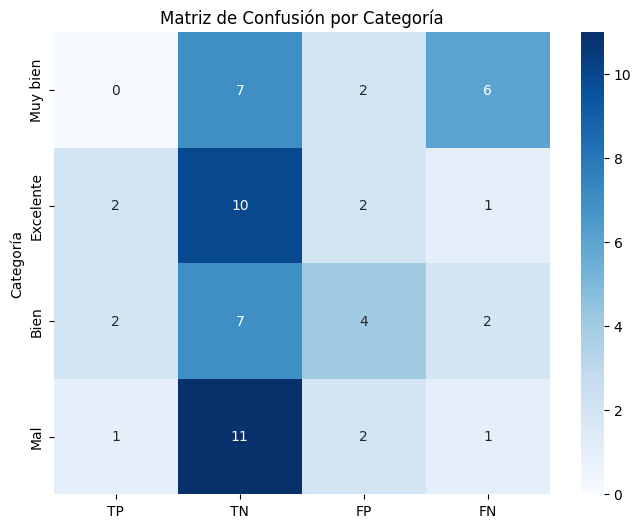

In [ ]:
# Matriz de confusión por categoría
# Seleccionar las 15 filas previamente seleccionadas
selected_data = df.sample(15, random_state=40)
X_selected = selected_data[['type_new', 'releaseYear', 'imdbNumVotes', 'drama', 'comedy', 'other']]
y_real = selected_data['rating_category']  # Etiquetas reales
y_pred = knn_predict(X_train, y_train, X_selected, k)  # Predicciones del modelo

# Convertir y_real y y_pred en arrays de numpy para poder hacer comparaciones
y_real = np.array(y_real)
y_pred = np.array(y_pred)

# Obtener todas las categorías únicas
categories = df['rating_category'].unique()

# Crear una lista para almacenar los resultados de la matriz de confusión
confusion_results = []

print("\nResultados detallados por categoría:")
for category in categories:
    # Binarizar las etiquetas reales y predichas para la categoría actual
    y_real_binary = (y_real == category).astype(int)
    y_pred_binary = (y_pred == category).astype(int)

    # Calcular TP, TN, FP, FN
    tp = ((y_real_binary == 1) & (y_pred_binary == 1)).sum()
    tn = ((y_real_binary == 0) & (y_pred_binary == 0)).sum()
    fp = ((y_real_binary == 0) & (y_pred_binary == 1)).sum()
    fn = ((y_real_binary == 1) & (y_pred_binary == 0)).sum()

    # Almacenar los resultados
    confusion_results.append({'Categoría': category, 'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn})

    # Mostrar resultados para la categoría
    print(f"\nCategoría: {category}")
    print(f"TP (True Positive): {tp}")
    print(f"TN (True Negative): {tn}")
    print(f"FP (False Positive): {fp}")
    print(f"FN (False Negative): {fn}")

# Crear un DataFrame para visualizar los resultados
confusion_df = pd.DataFrame(confusion_results)

# Mostrar el DataFrame con los resultados de la matriz de confusión
print("\nResumen de matriz de confusión por categoría:")
print(confusion_df)

# Visualización de la matriz de confusión (opcional)
# Aseguramos que 'Categoría' es una columna existente en confusion_df
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df.set_index('Categoría')[['TP', 'TN', 'FP', 'FN']], annot=True, fmt='d', cmap="Blues")
plt.title("Matriz de Confusión por Categoría")
plt.show()

COMPARACIÓN CON ALGORITMO KNN POR DEFECTO (SCIKIT-LERN)

In [ ]:
# *Implementación de KNN con scikit-learn*
# Entrenar el modelo KNN de scikit-learn
knn_sklearn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')  # Usar la distancia Manhattan
knn_sklearn.fit(X_train, y_train)

# Predicción usando el modelo KNN de scikit-learn
y_pred_sklearn = knn_sklearn.predict(X_test)

# Evaluar la precisión del modelo KNN de scikit-learn
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
print(f"\nPrecisión del modelo KNN con scikit-learn (distancia Manhattan): {accuracy_sklearn:.2f}")

# *Comparación entre los resultados obtenidos por ambos métodos*
print("\nComparación de la precisión entre ambos métodos:")
print(f"Precisión KNN manual: {accuracy:.2f}")
print(f"Precisión KNN scikit-learn: {accuracy_sklearn:.2f}")


Precisión del modelo KNN con scikit-learn (distancia Manhattan): 0.40

Comparación de la precisión entre ambos métodos:
Precisión KNN manual: 0.40
Precisión KNN scikit-learn: 0.40


**Conclusión Resumida:**
**Resultados Obtenidos:**

La precisión del modelo KNN manual con distancia Manhattan fue 0.40, lo que indica que el modelo predice correctamente el 40% de las veces.
Al comparar con la implementación de KNN de scikit-learn, la precisión fue idéntica, también 0.40, lo que sugiere que ambos modelos, tanto el manual como el de scikit-learn, tienen un rendimiento similar.
Matriz de Confusión: Los resultados detallados por categoría muestran las siguientes características:

"Muy bien": No hubo aciertos (TP=0), pero sí una cantidad significativa de falsos negativos (FN=6).
"Excelente": El modelo tuvo un buen desempeño con 2 verdaderos positivos (TP=2) y pocos falsos negativos (FN=1).
"Bien": Similar a "Excelente", con un desempeño moderado (TP=2), pero con más falsos positivos (FP=4).
"Mal": El modelo tuvo un buen desempeño con 1 verdadero positivo (TP=1) y pocos falsos negativos (FN=1).
Posibles Causas de Baja Precisión:

Desbalance de Clases: Las clases en el dataset parecen estar desbalanceadas, lo que podría haber influido en la baja precisión de las predicciones, ya que el modelo podría estar prediciendo las clases mayoritarias con mayor frecuencia.
Valor de k: El valor de k=5 puede no ser el óptimo. Un valor de k muy bajo o muy alto puede afectar el rendimiento, especialmente en datasets con desbalance.
Características Relevantes: Puede que las características seleccionadas (como tipo de película, año de lanzamiento, y número de votos) no sean suficientemente discriminativas para predecir correctamente las categorías de calificación.

**Mejoras y Recomendaciones:**

Ajuste del valor de k: Realizar un ajuste de hiperparámetros, probando varios valores de k mediante validación cruzada para encontrar el mejor rendimiento.
Manejo del desbalance de clases: Implementar técnicas como sobremuestreo, submuestreo o ponderación de clases para equilibrar la influencia de cada clase en el modelo.
Revisión de las características: Experimentar con más características o con técnicas de ingeniería de características para mejorar la capacidad predictiva del modelo.
Probar otros algoritmos de clasificación: Explorar otros modelos como árboles de decisión, random forests o SVM que podrían manejar mejor la distribución de las clases y las relaciones entre las variables.
En resumen, aunque el modelo KNN muestra una precisión relativamente baja, se pueden implementar varias mejoras para optimizar su rendimiento y compararlo con otros modelos que podrían ser más adecuados para el problema